In [1]:
# Show plots as part of the notebook (this is a Jupyter-specific operation)
%matplotlib inline
import time
import matplotlib.pyplot as plt
import requests
import xmltodict
# Standard library packages
import os

# Import Pandas and Seaborn
import pandas as pd
import seaborn as sns
import numpy as np

# Import Biopython tools for running local BLASTX
from Bio.Blast.Applications import NcbiblastxCommandline
from Bio.Blast.Applications import NcbiblastnCommandline

#For execution time tracking
from datetime import datetime
from pytz import timezone

In [2]:
now_time = datetime.now(timezone('America/Chicago'))
print(now_time.strftime('%I:%M:%S %p'))

04:31:08 PM


In [3]:
%%time
df = pd.read_csv('01_db_blastn_Nov112020_filtered_1e-20_subj.csv')

CPU times: user 43.9 s, sys: 10.7 s, total: 54.6 s
Wall time: 55.8 s


In [4]:
df['subject'].nunique()

9883

In [5]:
df = df['subject'].value_counts()
df = pd.Series(df)
df

NC_011600.1          150242
EU912438.1           148386
NC_046005.1          108333
MG739403.1           107667
NC_053868.1          106131
                      ...  
KX257198.1                1
DQ419510.1                1
DQ419500.1                1
JAACNO010002301.1         1
KM972453.1                1
Name: subject, Length: 9883, dtype: int64

In [6]:
df.to_csv('01_1_db_blastn_Nov112020_filtered_1e-20_subj_to_7level_taxonomy.csv')

In [7]:
df = pd.read_csv('01_1_db_blastn_Nov112020_filtered_1e-20_subj_to_7level_taxonomy.csv')

In [8]:
df.head()

,Unnamed: 0,subject
0,NC_011600.1,150242
1,EU912438.1,148386
2,NC_046005.1,108333
3,MG739403.1,107667
4,NC_053868.1,106131


In [9]:
df.columns.values[0] = "subject"
df.columns.values[1] = "count"

In [10]:
df.to_csv('01_1_db_blastn_Nov112020_filtered_1e-20_subj_to_7level_taxonomy.csv', index= False)

In [11]:
df = pd.read_csv('01_1_db_blastn_Nov112020_filtered_1e-20_subj_to_7level_taxonomy.csv')

In [12]:
df.head()

,subject,count
0,NC_011600.1,150242
1,EU912438.1,148386
2,NC_046005.1,108333
3,MG739403.1,107667
4,NC_053868.1,106131


# Retrieving (efetch) taxonomy heirarchy from NCBI

In [13]:
base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/{}"
db = "nuccore"

In [14]:
def get_taxon_name(tax_id):
    try:
        efetch = "efetch.fcgi?db={}&id={}&rettype=json".format(db, tax_id)
        efetch_response = requests.get(base_url.format(efetch))
        efetch_dict = xmltodict.parse(efetch_response.content)
        Definition = efetch_dict['GBSet']['GBSeq']['GBSeq_definition']
        Definition = Definition.split(',')
        Definition = Definition[0]
        time.sleep(0.5)
    except:
        Definition = tax_id
        pass
 
    return Definition

In [15]:
get_taxon_name ('NC_011600.1')

'Vaucheria litorea chloroplast'

In [16]:
def get_7level_taxonomy(tax_id):
    try:   
        efetch = "efetch.fcgi?db={}&id={}&rettype=json".format(db, tax_id)
        efetch_response = requests.get(base_url.format(efetch))
        efetch_dict = xmltodict.parse(efetch_response.content)
        GBSeq_taxonomy = efetch_dict['GBSet']['GBSeq']['GBSeq_taxonomy']
#        GBSeq_taxonomy_class = GBSeq_taxonomy.split("; ")
#        GBSeq_taxonomy_class = GBSeq_taxonomy_class[2]
        time.sleep(0.5)
    except:
        GBSeq_taxonomy = tax_id
        pass
    
    return GBSeq_taxonomy

In [17]:
get_7level_taxonomy ('NC_011600.1')

'Eukaryota; Sar; Stramenopiles; Ochrophyta; PX clade; Xanthophyceae; Vaucheriales; Vaucheriaceae; Vaucheria'

In [18]:
df.head()

,subject,count
0,NC_011600.1,150242
1,EU912438.1,148386
2,NC_046005.1,108333
3,MG739403.1,107667
4,NC_053868.1,106131


In [19]:
df['subject']

0             NC_011600.1
1              EU912438.1
2             NC_046005.1
3              MG739403.1
4             NC_053868.1
              ...        
9878           KX257198.1
9879           DQ419510.1
9880           DQ419500.1
9881    JAACNO010002301.1
9882           KM972453.1
Name: subject, Length: 9883, dtype: object

In [20]:
%%time
def enrich_dataset(df):
    taxon_value = df['subject']
    Seven_Level_Taxonomy = get_7level_taxonomy(taxon_value)
    df['7Level_Taxonomy'] = Seven_Level_Taxonomy
    return df

CPU times: user 17 µs, sys: 4 µs, total: 21 µs
Wall time: 39.1 µs


In [21]:
%%time
df = df.apply(enrich_dataset, axis=1)

CPU times: user 6min 53s, sys: 20.1 s, total: 7min 14s
Wall time: 3h 58min 28s


In [22]:
df.to_csv('04_db_blastn_Nov112020_filtered_1e-20_subj_to_7level_taxonomy_enriched.csv', index= False)

# Process Taxonomic Levels, Extract Information¶

In [23]:
df = pd.read_csv('04_db_blastn_Nov112020_filtered_1e-20_subj_to_7level_taxonomy_enriched.csv')

In [24]:
df['7Level_Taxonomy'].nunique()

944

In [25]:
df.head(5)

,subject,count,7Level_Taxonomy
0,NC_011600.1,150242,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...
1,EU912438.1,148386,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...
2,NC_046005.1,108333,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...
3,MG739403.1,107667,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...
4,NC_053868.1,106131,Eukaryota; Sar; Stramenopiles; Stramenopiles i...


In [26]:
def taxlevel (tax):
    tax = tax.split("; ")
    tax_len = len(tax)
    
    return tax_len

In [27]:
def enrich_dataset(df):
    taxon_level = df['7Level_Taxonomy']
    Seven_Level_Taxonomy = taxlevel(taxon_level)
    df['7Level_Lenght'] = Seven_Level_Taxonomy
    return df

In [28]:
%%time
df = df.apply(enrich_dataset, axis=1)

CPU times: user 6.01 s, sys: 2.43 ms, total: 6.01 s
Wall time: 6.01 s


In [29]:
df.head()

,subject,count,7Level_Taxonomy,7Level_Lenght
0,NC_011600.1,150242,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...,9
1,EU912438.1,148386,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...,9
2,NC_046005.1,108333,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...,9
3,MG739403.1,107667,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...,9
4,NC_053868.1,106131,Eukaryota; Sar; Stramenopiles; Stramenopiles i...,5


In [30]:
df['7Level_Lenght'].value_counts()

2     2282
6     2129
9     1167
4      947
8      939
7      783
10     516
5      412
3      347
11     262
1       99
Name: 7Level_Lenght, dtype: int64

In [31]:
df.shape

(9883, 4)

In [32]:
df["Levels"] = df["7Level_Lenght"].replace({11: "11_Levels",
                                           10: "10_Levels",
                                           9: "9_Levels",
                                           8: "8_Levels",
                                           7: "7_Levels",
                                           6: "6_Levels",
                                           5: "5_Levels",
                                           4: "4_Levels",
                                           3: "3_Levels",
                                           2: "2_Levels",
                                           1: "1_Level",
                                           })

In [33]:
df.head()

,subject,count,7Level_Taxonomy,7Level_Lenght,Levels
0,NC_011600.1,150242,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...,9,9_Levels
1,EU912438.1,148386,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...,9,9_Levels
2,NC_046005.1,108333,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...,9,9_Levels
3,MG739403.1,107667,Eukaryota; Sar; Stramenopiles; Ochrophyta; PX ...,9,9_Levels
4,NC_053868.1,106131,Eukaryota; Sar; Stramenopiles; Stramenopiles i...,5,5_Levels


<AxesSubplot:>

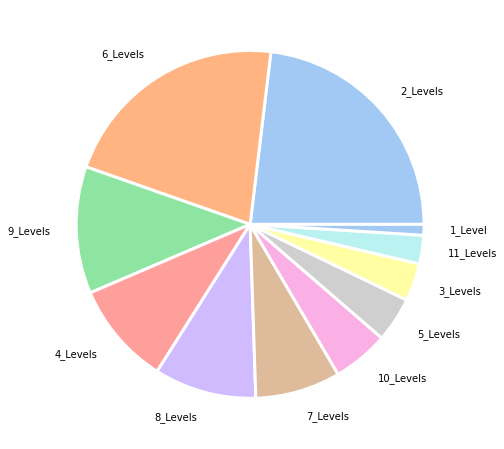

In [34]:
plt.rcParams["figure.figsize"] = (30,8)
colors = sns.color_palette('pastel')[0:11]
df['Levels'].value_counts().plot.pie(labeldistance=1.15, 
                                     wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
                                     colors=colors,
                                     ylabel='')

<AxesSubplot:>

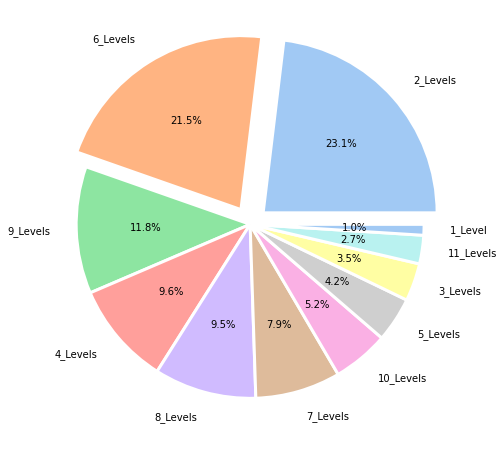

In [35]:
plt.rcParams["figure.figsize"] = (30,8)
colors = sns.color_palette('pastel')[0:11]
explode = (0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
df['Levels'].value_counts().plot.pie(labeldistance=1.15, 
                                     wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
                                     colors=colors,
                                     ylabel='',
                                     autopct='%1.1f%%',
                                    explode = explode)

<AxesSubplot:>

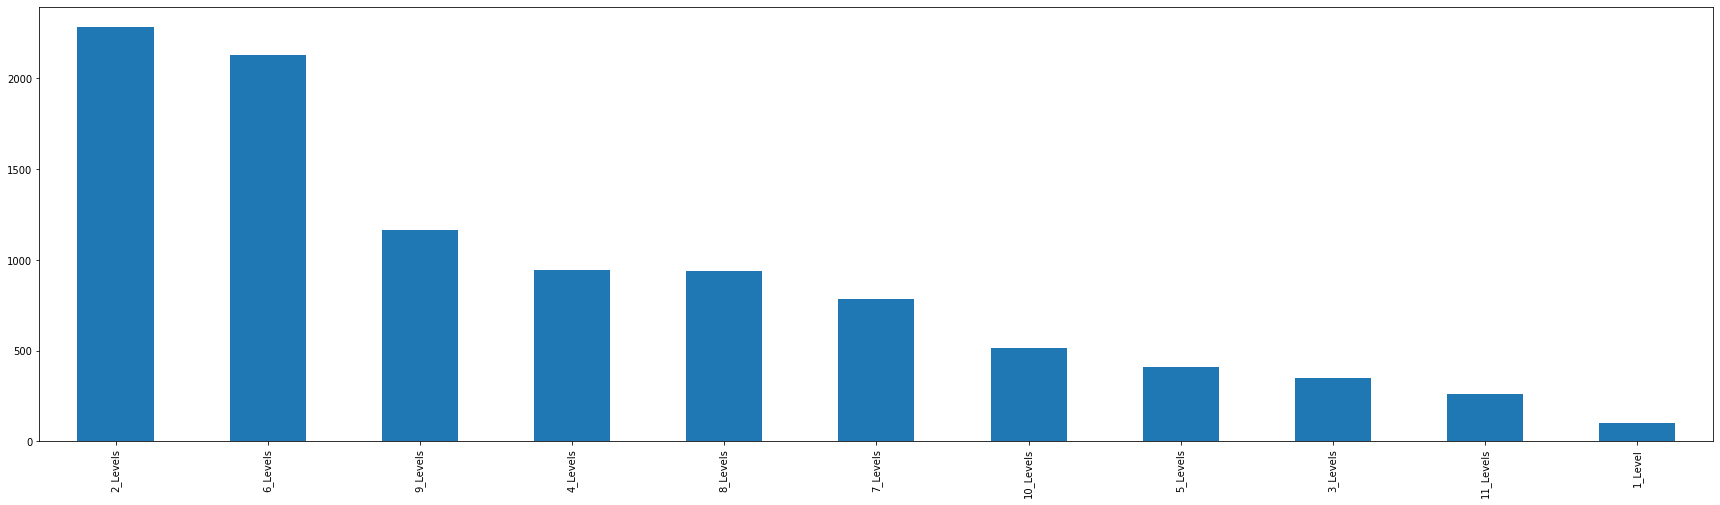

In [36]:
df['Levels'].value_counts().plot.bar()

##### Saving the count of taxonomic levels of each subject (blasted accession numbers from Nucleotide database of NCBI)¶

In [37]:
df.to_csv('05_db_blastn_Nov112020_filtered_1e-20_subj_to_7level_taxonomy_enriched.csv', index= False)